In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

In [2]:
!pip install shap
import shap
#clear the output 
from IPython.display import clear_output
clear_output(wait=False)

In [3]:
df = pd.read_csv('./dataset/data_file.csv', sep=',')

categorical_columns = ['Machine', 'MajorImageVersion', 'MajorOSVersion', 'MajorLinkerVersion', 'MinorLinkerVersion', 'DllCharacteristics', 'NumberOfSections']
df[categorical_columns] = df[categorical_columns].astype('category')

binary_columns = ['Benign', 'BitcoinAddresses']

numeric_columns = df.select_dtypes(include=['int64']).columns.difference(binary_columns)

df.drop(columns=['FileName', 'md5Hash'], inplace=True)

df['LinkerVersion'] = df['MajorLinkerVersion'].astype(str) + '.' + df['MinorLinkerVersion'].astype(str)
df['LinkerVersion'] = df['LinkerVersion'].astype('category')
df.drop(columns=['MajorLinkerVersion', 'MinorLinkerVersion'], inplace=True)

categorical_columns = [col for col in categorical_columns if col not in ['MajorLinkerVersion', 'MinorLinkerVersion']]
categorical_columns.append('LinkerVersion')

df.drop(columns=['BitcoinAddresses'], inplace=True)

### AI models explainability

As we've seen before, for our classification we used Logistic Regression and Random Forest, which have notable differences in terms of explainability. In fact, Linear Regression is a white box model, meaning that is easily explainable by displaying the coefficients used for the classification. On the other hand, Random Forest is a black box model,  meaning that we need post-hoc techniques such as SHAP values or LIME to be able to explain the model.
Since we've seen that categorical features offer a very good balance between performances and computational effort, we're going to explain Logistic Regression and Random Forest when using categorical variables for classification.

#### Logistic Regression Explainability using coefficients

For Logistic Regression it's possible to display the coefficients assigned to each feature to see the importance of each one of them

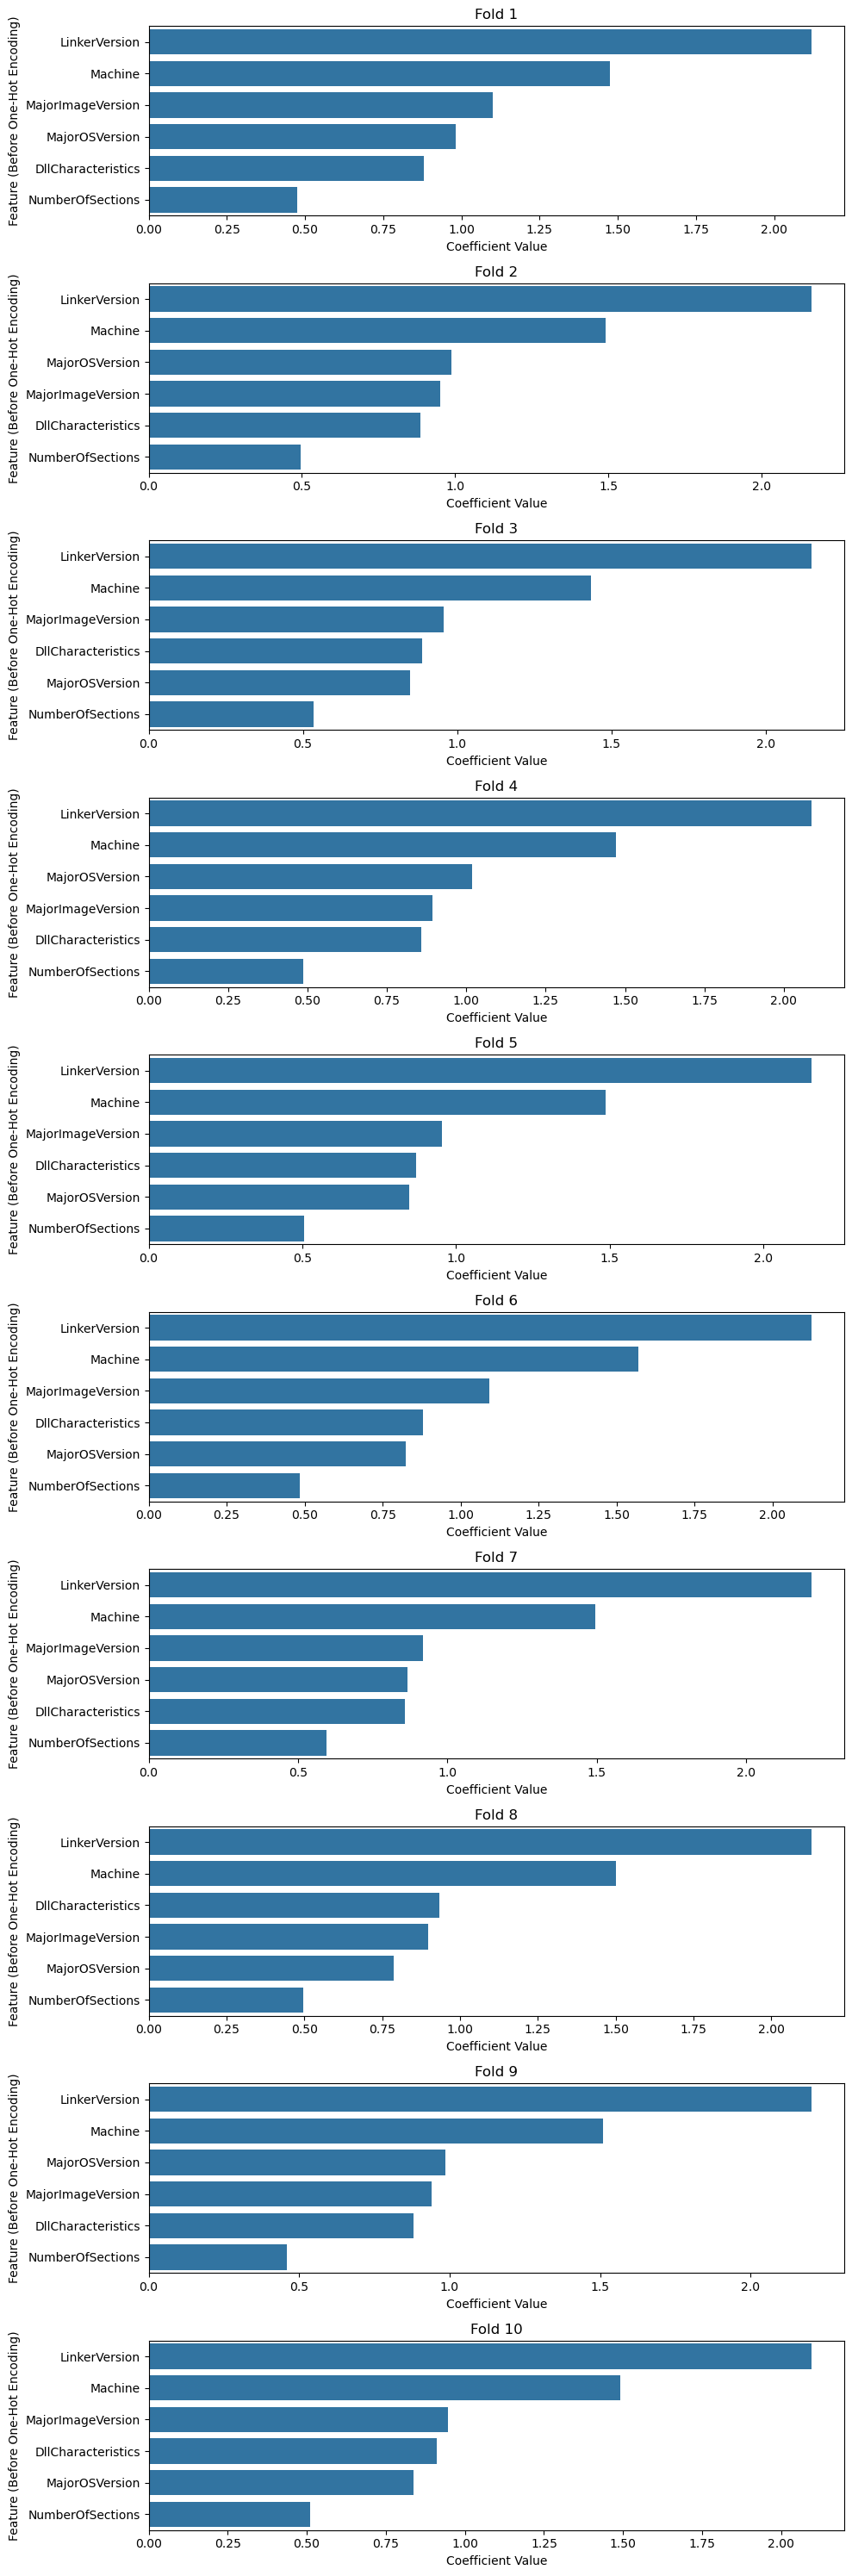

In [4]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 30))

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Extract model coefficients
    coefficients = pipeline.named_steps['classifier'].coef_[0]

    # Extract the one-hot encoded feature names
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat_transform']
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

    # Create a mapping from one-hot encoded features to their original categorical feature
    feature_coefficients = {}

    for feature in categorical_columns:
        # Find all one-hot encoded features that belong to the current categorical feature
        matching_features = [f for f in ohe_feature_names if f.startswith(feature)]
    
        # Get their indices in the coefficient array
        indices = [ohe_feature_names.tolist().index(f) for f in matching_features]

        # Aggregate coefficients (e.g., by taking the mean)
        feature_coefficients[feature] = np.mean([coefficients[i] for i in indices if coefficients[i] > 0])

    # Print the coefficients for this fold
    # print(f"Fold {i + 1}:")
    # for feature, coef in feature_coefficients.items():
    #     print(f"  Feature: {feature}, Coefficient: {coef}")
    # print("\n")  # Empty line for readability

    # Plot for this fold in the appropriate subplot
    coef_df_fold = pd.DataFrame.from_dict(feature_coefficients, orient='index', columns=['Coefficient'])
    coef_df_fold = coef_df_fold.sort_values(by='Coefficient', ascending=False)

    # Plot on the appropriate axis (subplot)
    ax = axes[i]
    sns.barplot(x=coef_df_fold['Coefficient'], y=coef_df_fold.index, ax=ax)
    ax.set_title(f"Fold {i + 1}")
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature (Before One-Hot Encoding)")

plt.tight_layout()
plt.show()


To be able to print the coefficients for the logistic regression the model's learned coefficients are extracted and interpreted as measures of feature importance. Because one-hot encoding expands each categorical variable into several binary variables, the coefficients of these encoded features are grouped and averaged to reflect the importance of the original categorical variable.

Finally, the aggregated feature importance scores are visualized using bar plots for each fold, allowing for comparison of feature influence across different training/test splits.

Observing the graph we can see that the features LinkerVersion and machine are consistently considered important for classification on each fold being put at respectively at the first and at the second place. On third place we have alternatively MajorImageVersion, MajorOSVersion and DllCharacteristics, meaning that these are alternatively important depending on the fold.

#### Models Explainability using SHAP

SHAP is a popular method for interpretable machine learning, based on game theory. It assigns SHAPley values to each feature in a model, quantifying its contribution to a particular prediction. SHAP is widely used because:

It provides a consistent and fair way to distribute feature importance.
It explains both global feature importance (how features influence predictions overall) and local explanations (why a model made a specific prediction).
It works well with tree-based models, deep learning, and linear models like Logistic Regression.

##### Logistic Regression Explainability using SHAP

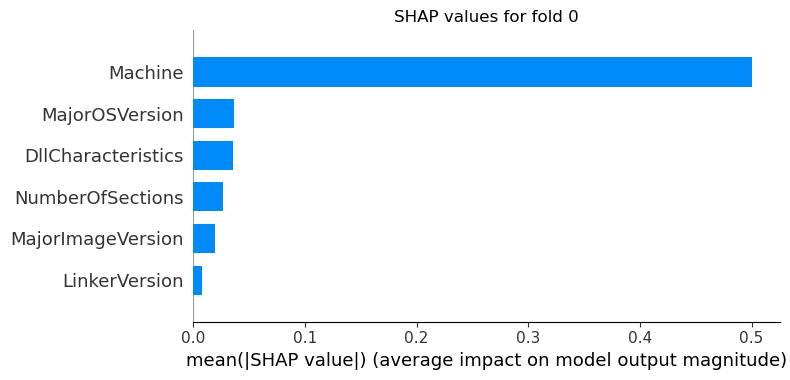

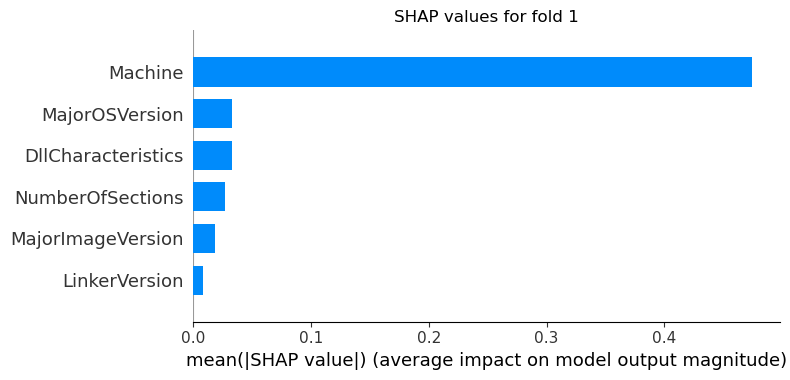

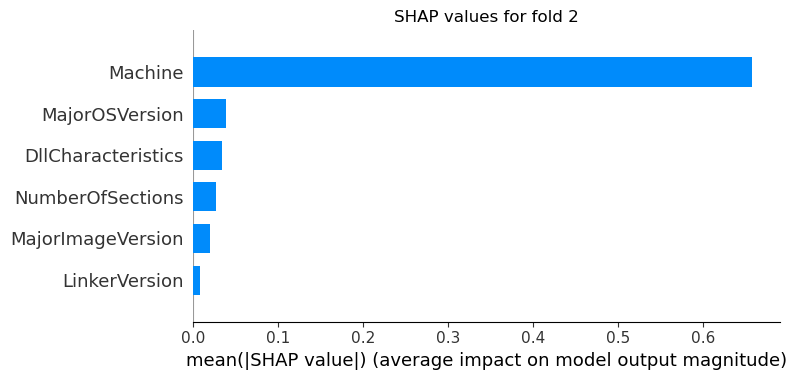

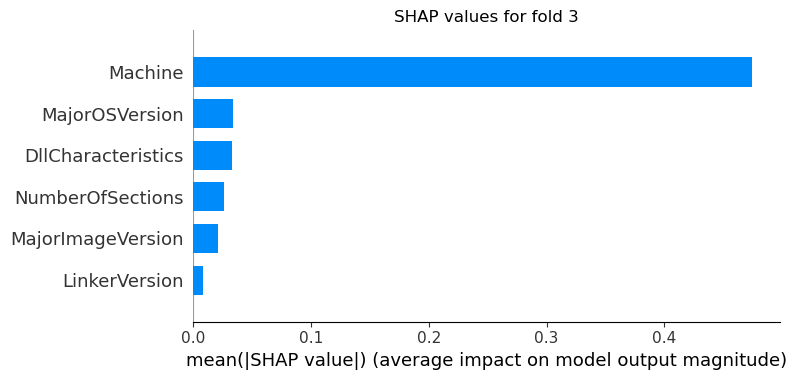

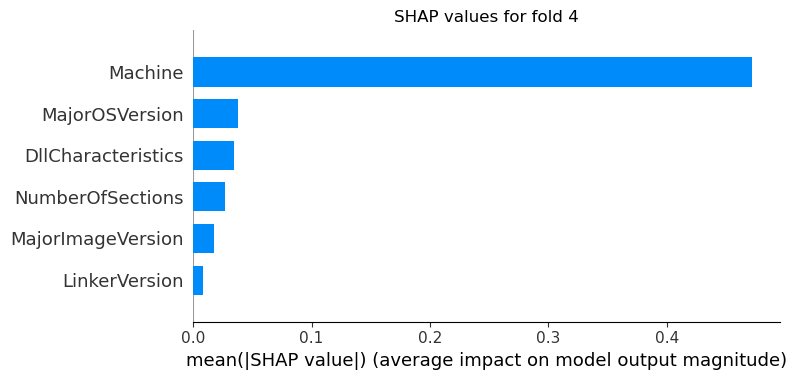

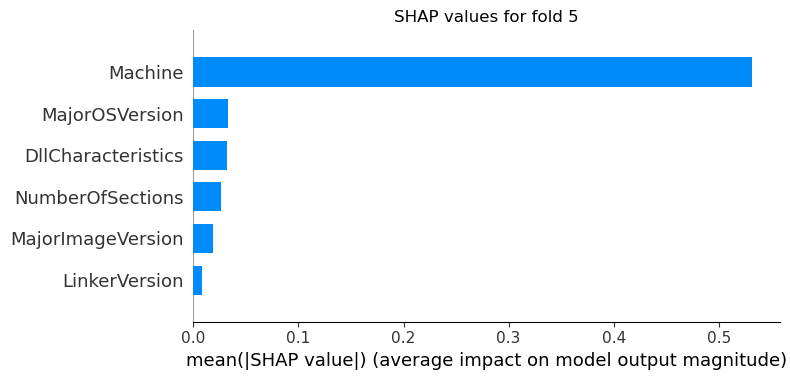

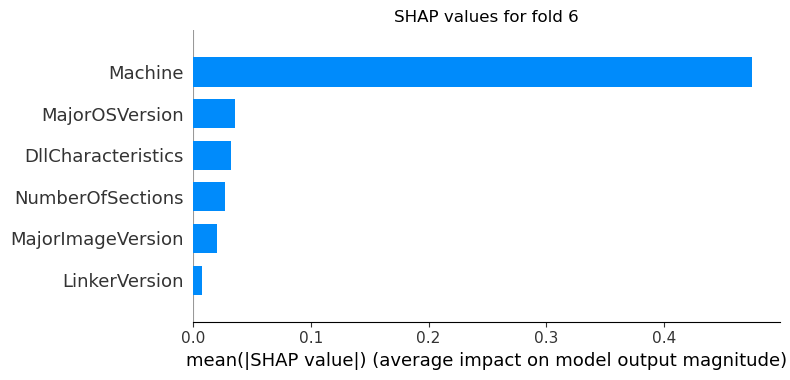

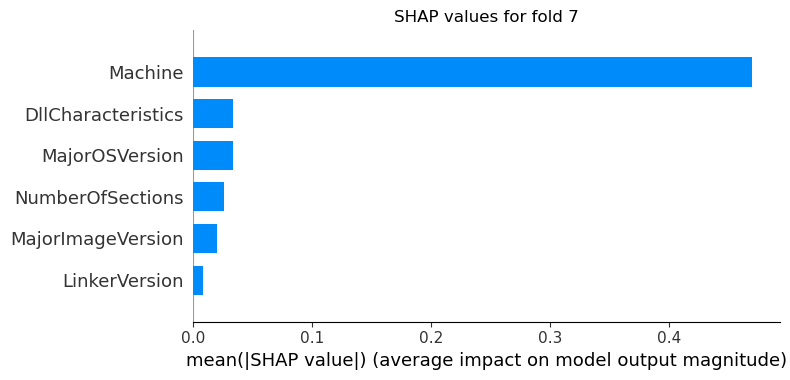

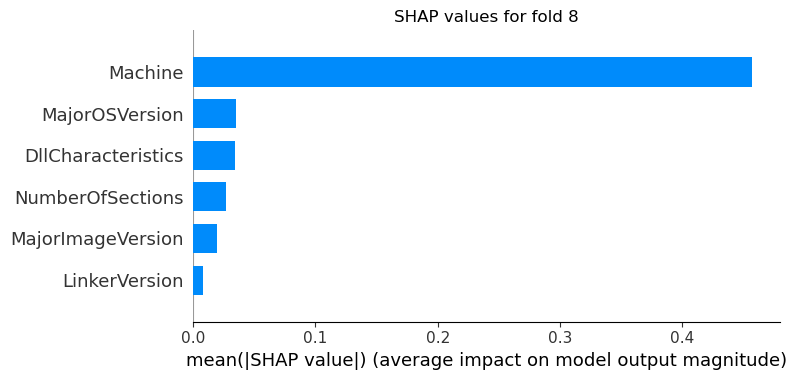

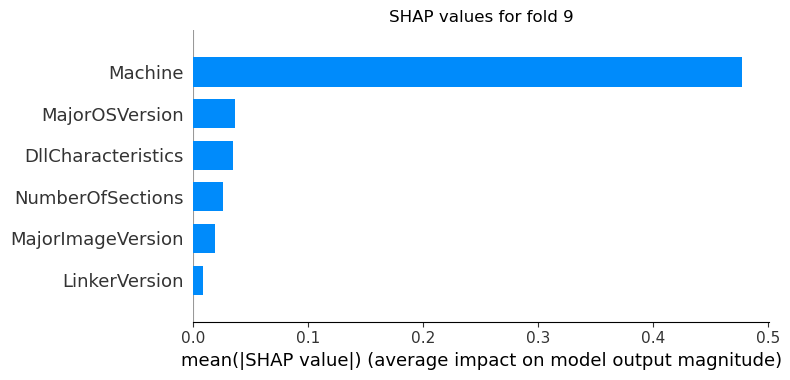

In [5]:
X = df[categorical_columns]  
y = df["Benign"]
 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transform", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)
 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
 


for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat_transform"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained LogisticRegression
    explainer = shap.Explainer(pipeline.named_steps["classifier"],pipeline.named_steps["preprocessor"].transform(X_test))
    shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_test))
 

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df = pd.DataFrame(shap_values.values, columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)

    # Initialization of dictionary to contain aggregate values 
    agg_shap_per_row = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature
            row_agg_shap[orig_feat] = row[enc_feats].mean()
            
        agg_shap_per_row.append(row_agg_shap)

    # Converts the list of aggregated results into a DataFrame
    agg_shap_df = pd.DataFrame(agg_shap_per_row)



    plt.title(f"SHAP values for fold {i}")
    shap.summary_plot(agg_shap_df.values, features=agg_shap_df.columns, plot_type="bar")
    plt.show()


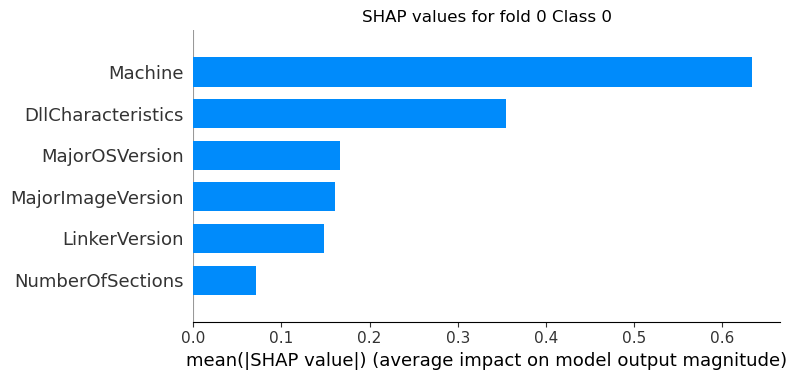

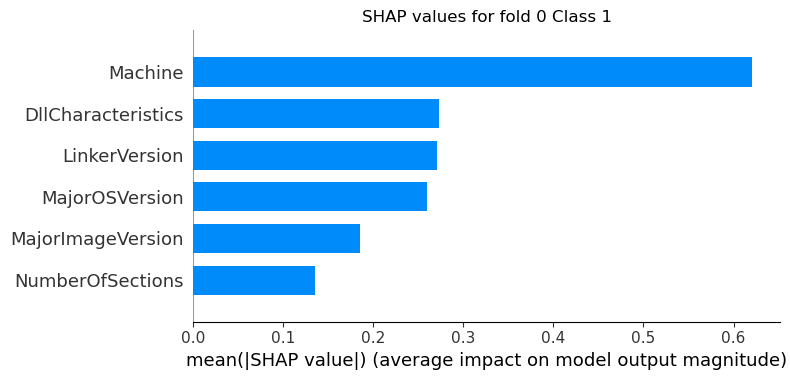

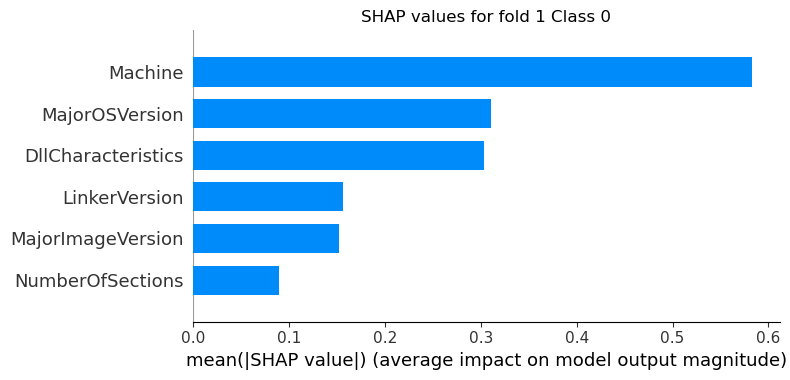

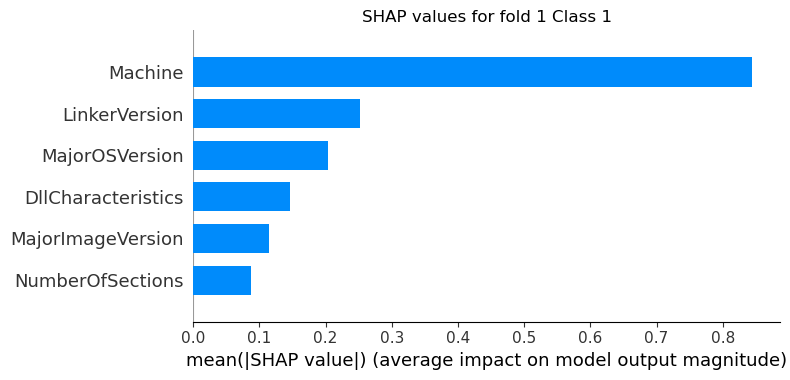

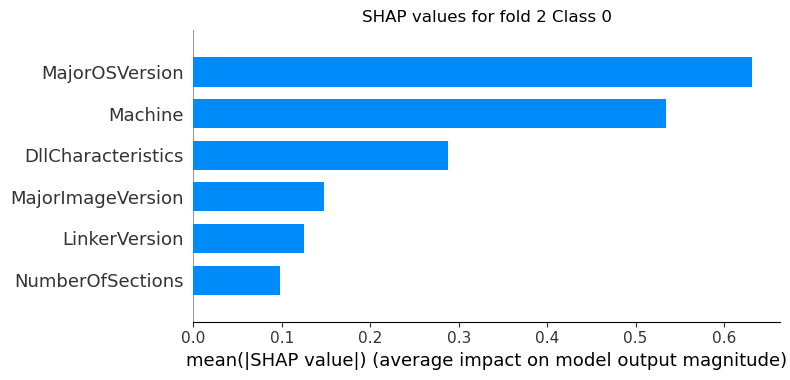

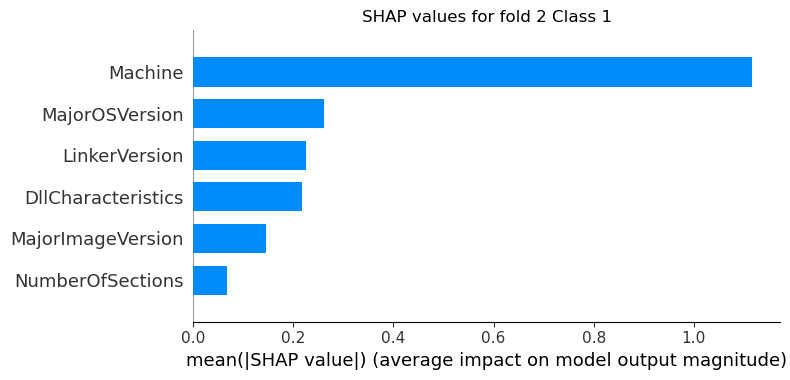

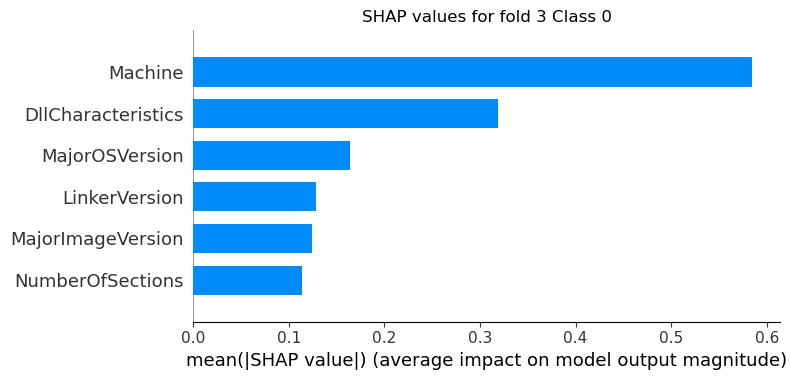

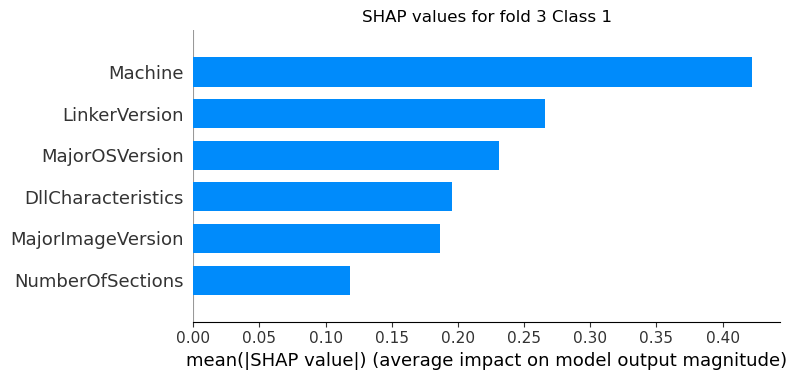

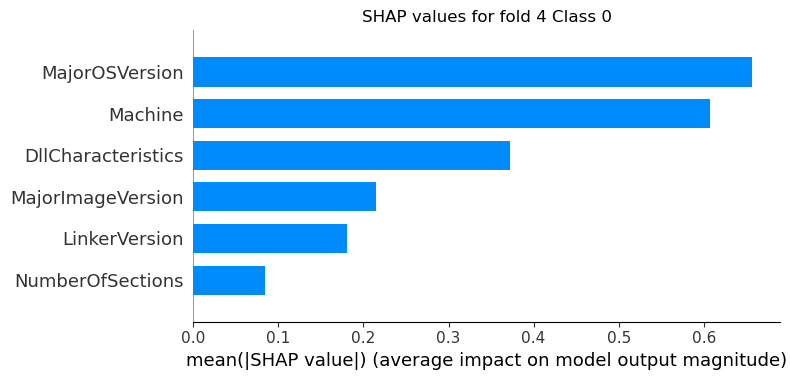

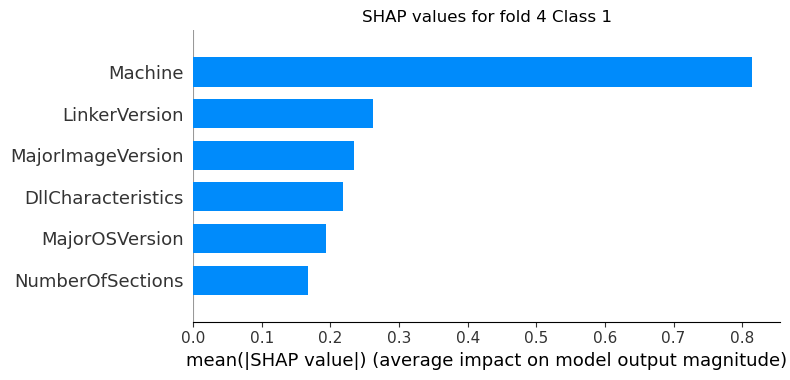

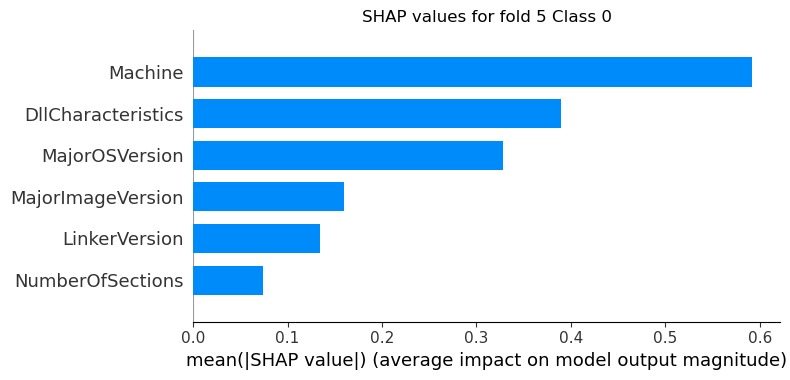

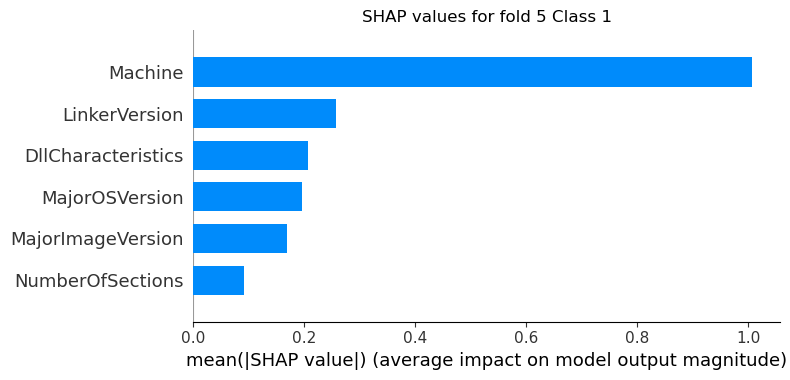

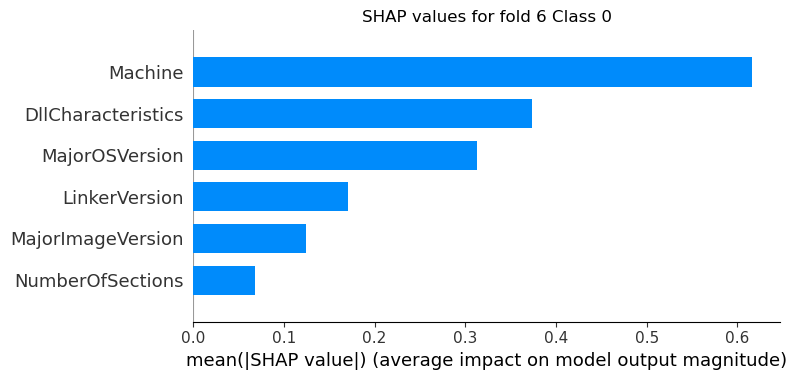

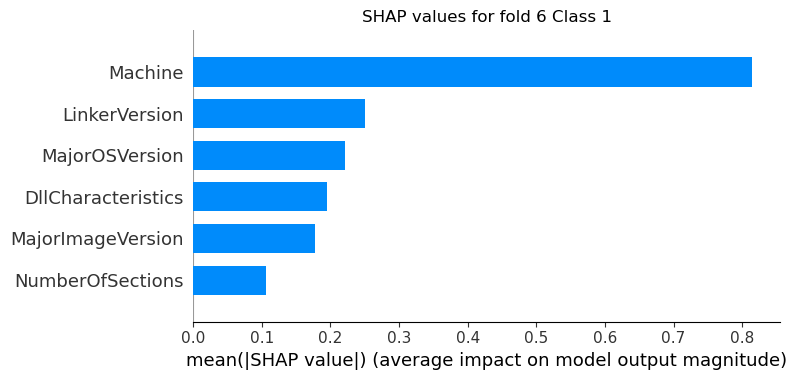

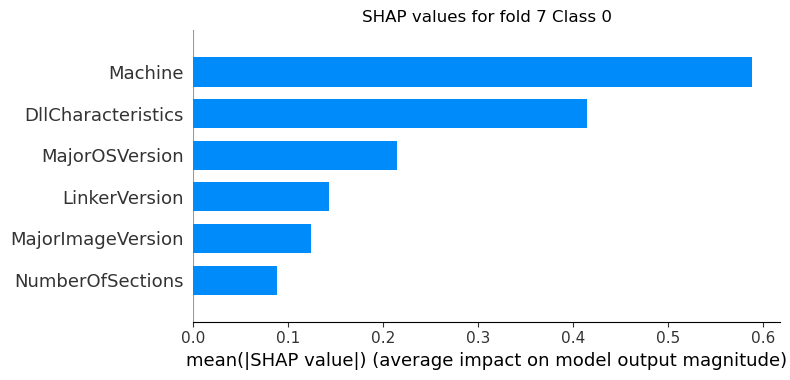

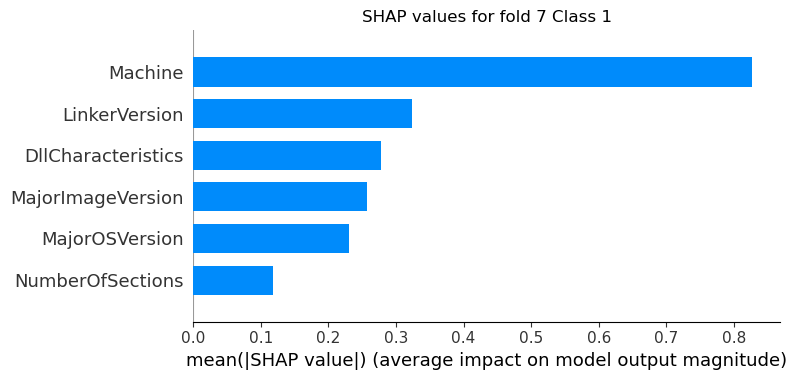

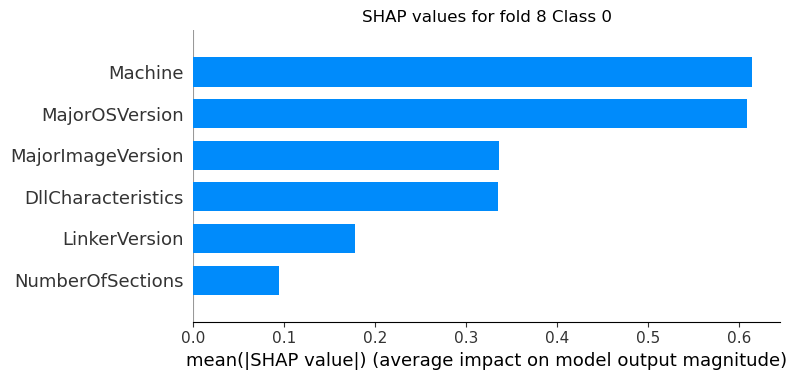

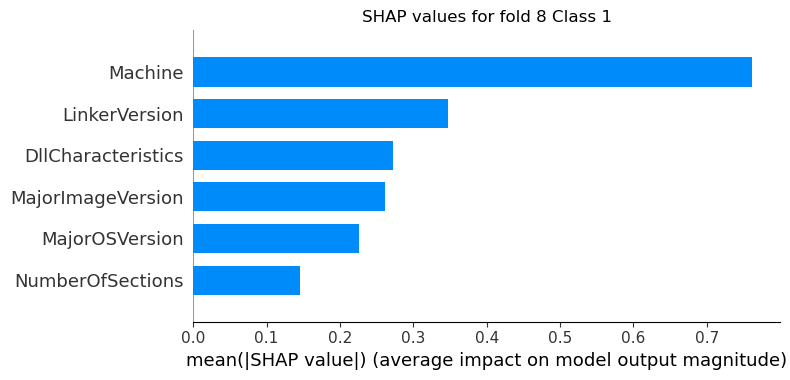

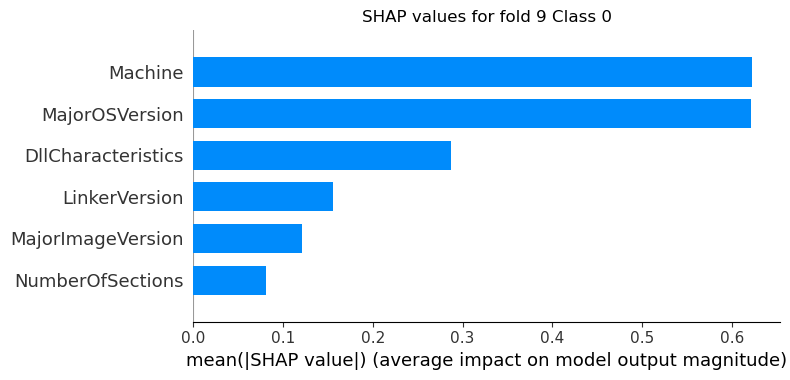

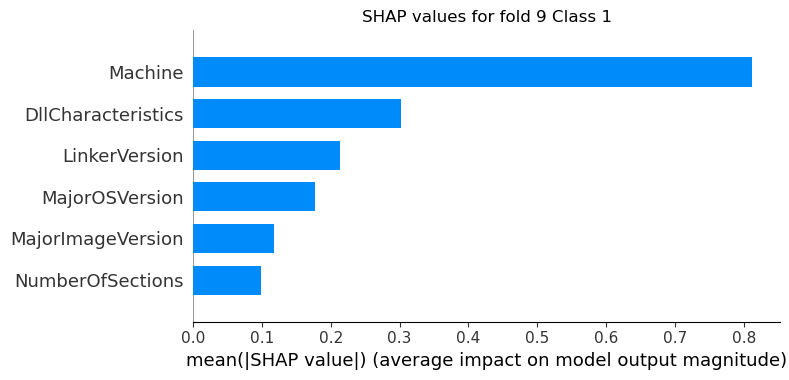

In [6]:
X = df[categorical_columns]  
y = df["Benign"]
 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transform", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)
 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
 


for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat_transform"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained LogisticRegression
    explainer = shap.Explainer(pipeline.named_steps["classifier"],pipeline.named_steps["preprocessor"].transform(X_test))
    shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_test))
 

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df = pd.DataFrame(shap_values.values, columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)

    # Initialization of dictionary to contain aggregate values 
    # class 0 -> ('Malicious', value 0)
    # class 1 -> ('Benign', value 1)
    agg_shap_per_row_class0 = []
    agg_shap_per_row_class1 = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap_class0 = {}
        row_agg_shap_class1 = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature considering that:
            # - Positive SHAP value means positive impact on prediction, leading the model to predict 1
            # - Negative SHAP value means negative impact, leading the model to predict 0.
            shap_values_class0 = row[enc_feats][row[enc_feats] < 0].mean()  # Media solo dei valori negativi (Classe 0)
            shap_values_class1 = row[enc_feats][row[enc_feats] > 0].mean()  # Media solo dei valori positivi (Classe 1)
            
            # Add aggregated results for class 0 and class 1
            if shap_values_class0 != 0:
                row_agg_shap_class0[orig_feat] = shap_values_class0
            if shap_values_class1 != 0:
                row_agg_shap_class1[orig_feat] = shap_values_class1
        
        # Add the aggrgated results to the correct list
        agg_shap_per_row_class0.append(row_agg_shap_class0)
        agg_shap_per_row_class1.append(row_agg_shap_class1)

    # Converts the list of aggregated results into a DataFrame for class 0 and class 1
    agg_shap_df_class0 = pd.DataFrame(agg_shap_per_row_class0)
    agg_shap_df_class0 = agg_shap_df_class0.fillna(0)
    agg_shap_df_class0 = agg_shap_df_class0.abs()

    agg_shap_df_class1 = pd.DataFrame(agg_shap_per_row_class1)
    agg_shap_df_class1 = agg_shap_df_class1.fillna(0)

    # Show the data frames 
    # print(f"FOLD {i}\n")
    # print("SHAP values for class 0:")
    # print(agg_shap_df_class0.head(20))
    # print("\nAggregated SHAP values for class 1:")
    # print(agg_shap_df_class1.head(20))


    plt.title(f"SHAP values for fold {i} Class 0")
    shap.summary_plot(agg_shap_df_class1.values, features=agg_shap_df_class1.columns, plot_type="bar")
    plt.show()
    plt.title(f"SHAP values for fold {i} Class 1")
    shap.summary_plot(agg_shap_df_class0.values, features=agg_shap_df_class0.columns, plot_type="bar")
    plt.show()
    


 
    

How SHAP is Used in This Code

This code applies SHAP to a Logistic Regression model trained on categorical data. Since the categorical features are transformed using One-Hot Encoding (OHE) before training, the SHAP values are initially computed for the encoded features. However, the goal is to understand the importance of the original categorical features before encoding, so the SHAP values for each feature’s one-hot encoded components are aggregated.

Step-by-Step Breakdown
Data Preprocessing and Model Training
The categorical features are extracted from the dataset.
A preprocessing pipeline is created using OneHotEncoder to transform categorical variables.
A Logistic Regression model is trained using 10-fold Stratified Cross-Validation.
Extracting One-Hot Encoded Feature Names
After training, the OneHotEncoder feature names are retrieved to understand how categorical features were expanded.
SHAP Explanation Computation
A SHAP explainer is initialized using the trained Logistic Regression model.
The SHAP values are computed for the transformed input data. These values indicate the contribution of each one-hot encoded feature to the model’s predictions.
Mapping SHAP Values Back to Original Features
Since each categorical feature was split into multiple one-hot encoded components, SHAP values for these components are aggregated (using the mean of absolute values).
This gives a single importance score per original categorical feature.
Visualization
A bar plot is generated using Seaborn, displaying SHAP feature importance for the original categorical features before encoding.
Colors are assigned based on feature names to enhance readability.

#### Explainability of Random Forest

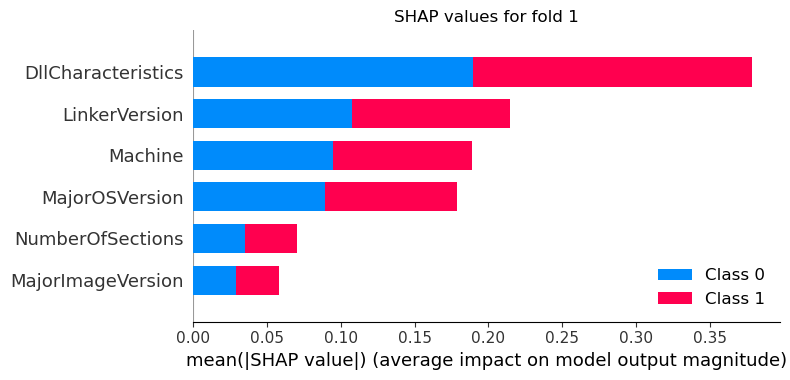

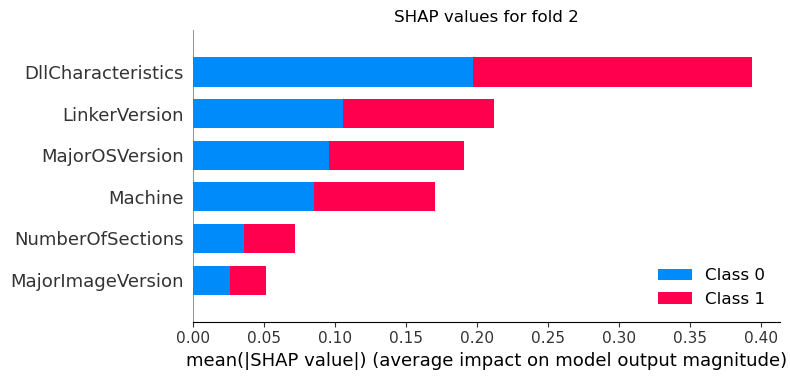

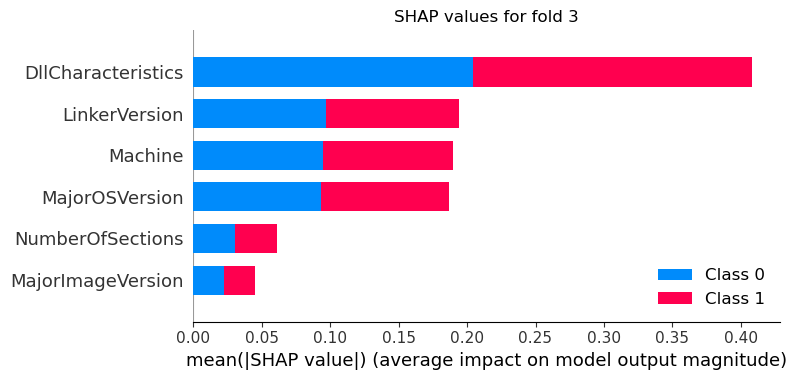

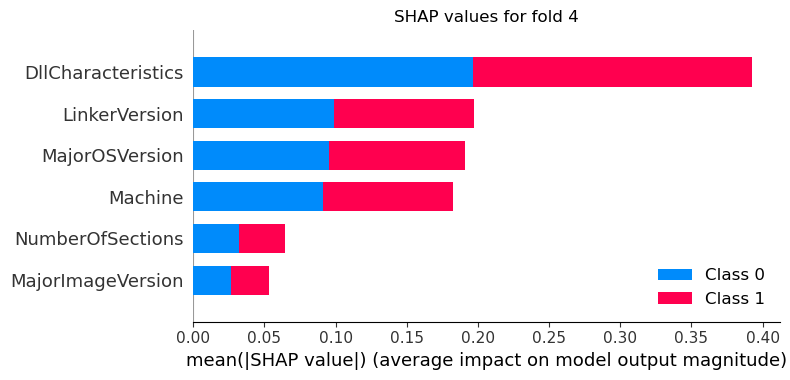

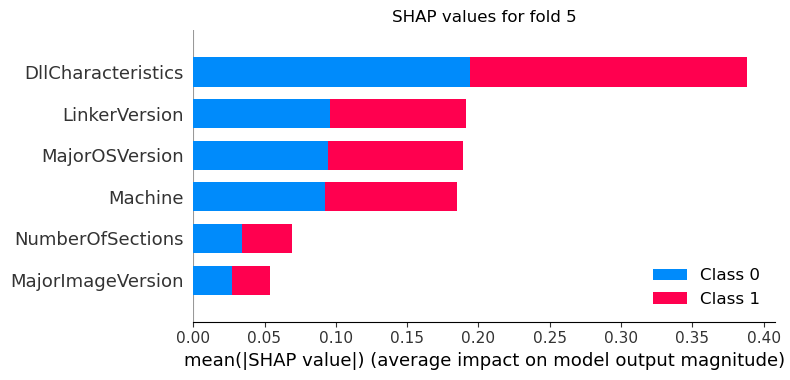

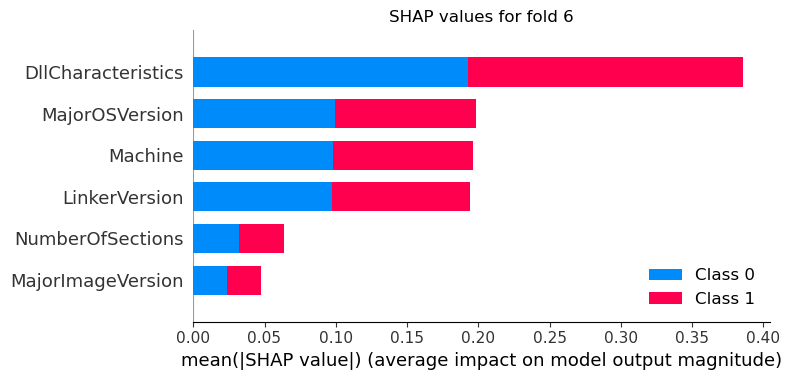

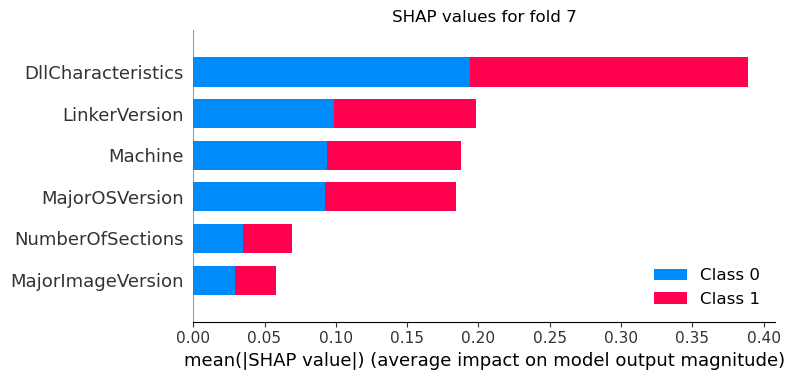

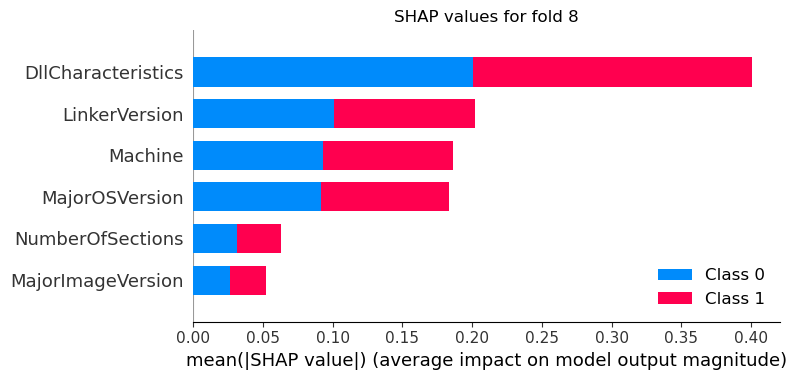

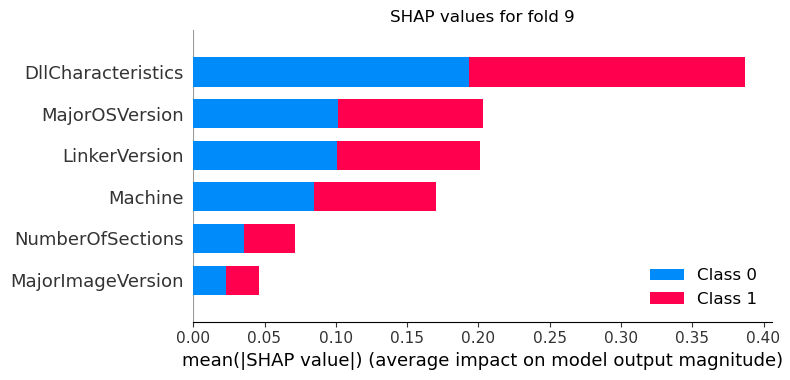

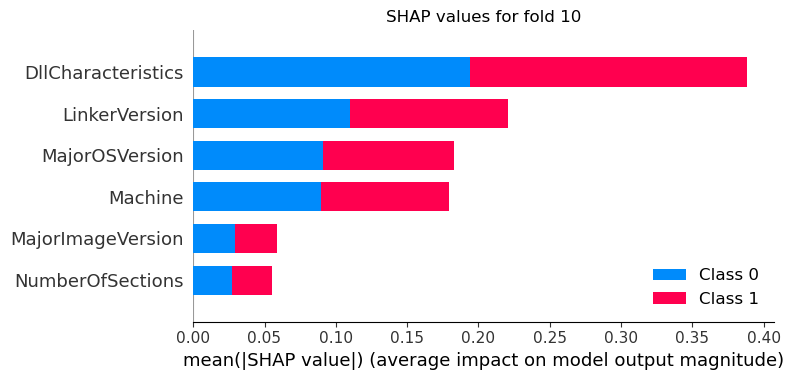

In [5]:
X = df[categorical_columns]
y = df['Benign']


pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    model = pipeline.named_steps['classifier']  # trained model to be passed to the explainer

    # use SHAP to explain predictions
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    # nel caso di una classificazione binaria, shap_values è una lista che contiene due array bidimensionali: uno per ogni classe.
    # ogni array ha lo stesso numero di righe di X_test e un numero di colonne pari alle features, e ogni riga rappresenta
    # l'influenza di ciascuna feature sulla previsione di quella classe per l'istanza di test corrispondente.
    # - shap_values[0]: è un array di dimensione (n_samples, n_features) che contiene i valori SHAP per la classe 0.
    # - shap_values[1]: è un array di dimensione (n_samples, n_features) che contiene i valori SHAP per la classe 1.
   
    plt.title(f"SHAP values for fold {i+1}")
    shap.summary_plot(shap_values, X_test, plot_type="bar")

In this case we applied the SHAP post-hoc technique to show the importance of each variable in every fold.
After training the model on each fold we compute SHAP values for each categorical variable. In binary classification, SHAP returns separate arrays for each class, showing how each feature contributes to the predicted probability for class 0 or class 1.
The plots visualize the average absolute SHAP value for each feature, providing a clear and interpretable ranking of the most influential features across all test instances in that fold.